# Analysis of HER2 Positive Patients using Microbiopsies ()

In [8]:
#Supporting packages for analysis
import numpy as np
import pandas as pd

#KSTAR imports
from kstar import config, helpers, kstar_runner
from kstar.activity import kstar_activity
from kstar.plot import dotplot

import conf #This is the local config file for setting the supplements directory to your local environment


#Set matplotlib defaults for arial 12 point font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 12
import matplotlib.pyplot as plt

#Directory where KSTAR Supplemental data was set 
odir = conf.SUPPLEMENTS_DIR+'Supplements/SupplementaryData/BreastCancer/Microbiopsy_Satpathy2020/'

#load the Mann Whitney activities and FPR for Tyrosine predictions, 
#it will be faster and less data than loading all KSTAR outputs
activities = pd.read_csv(odir+'/RESULTS/micro_biopsy_Y_mann_whitney_activities.tsv', sep='\t', index_col=0)
fpr = pd.read_csv(odir+'/RESULTS/micro_biopsy_Y_mann_whitney_fpr.tsv', sep='\t', index_col=0)


        
#set preferred kinase names (make a kinase_dict)
kinase_dict = {}
for kinase in activities.index:
    kinase_dict[kinase] = conf.KINASE_MAP.loc[kinase,'Preferred Name']

## Agglomerative clustering of all patients and kinases, with context

In [5]:
s1 = pd.read_csv(odir+'sample_metadata_mirobiopsy.csv')
#add data to the Sample ID column so they can be matched
id_col = []
for index, row in s1.iterrows():
    id_col.append('data:'+row['Sample ID'])
s1['ID'] = id_col

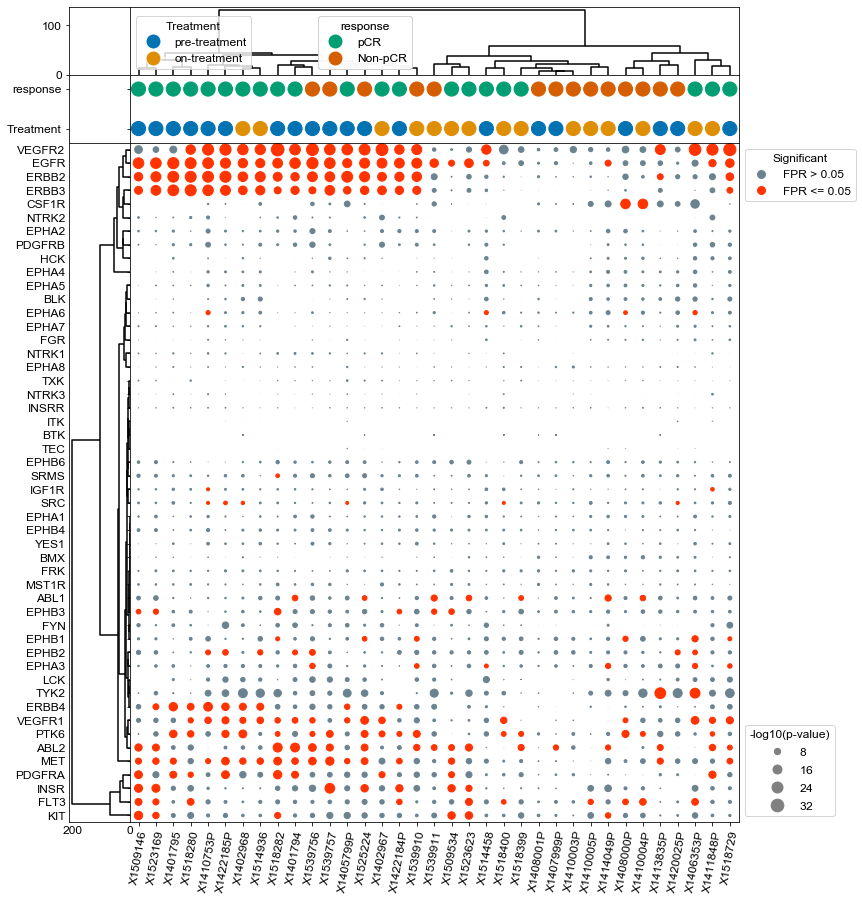

In [11]:
# PLot all samples with their context information about treatment and pCR status
fig, axes = plt.subplots(figsize = (12, 15), 
        nrows = 3, ncols = 2, 
        sharex = 'col', 
        sharey = 'row',
        gridspec_kw = {
            'height_ratios':[.1,0.1, 1], 
            'width_ratios':[0.1,1]
        },)
fig.subplots_adjust(wspace=0, hspace=0)

dots = dotplot.DotPlot(results, 
                       fpr, 
                       figsize = (10,15), 
                       dotsize = 5, 
                       legend_title='-log10(p-value)',
                      kinase_dict=kinase_dict)
#Cluster changes the sorting of the values array, so be sure to plot context last so that it is in the same sort.
#dots.drop_kinases_with_no_significance()

dots.cluster(orientation = 'left', ax = axes[2,0], method='ward')
dots.cluster(orientation = 'top', ax = axes[0,1], method='ward')
dots.context(ax=axes[1,1],info = s1, id_column = 'ID', context_columns = ['Treatment', 'response'], orientation = 'top', dotsize =200, markersize= 15 )

dots.dotplot(ax = axes[2,1])

plt.xticks(rotation = 80, FontSize=12)
plt.yticks(FontSize=12)
plt.savefig(odir+'microbiopsy_all.pdf', bbox_inches='tight')

## Agglomerative clustering of all patients and all significant kinases, with context

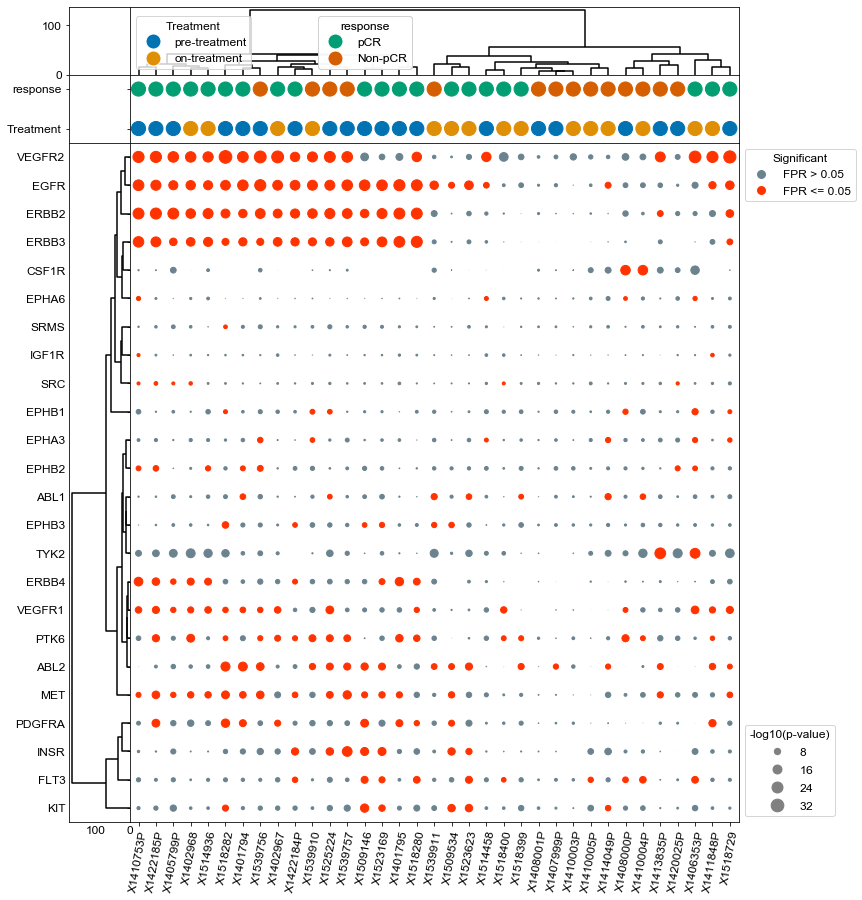

In [12]:
# PLot all samples with their context information about treatment and pCR status
fig, axes = plt.subplots(figsize = (12, 15), 
        nrows = 3, ncols = 2, 
        sharex = 'col', 
        sharey = 'row',
        gridspec_kw = {
            'height_ratios':[.1,0.1, 1], 
            'width_ratios':[0.1,1]
        },)
fig.subplots_adjust(wspace=0, hspace=0)

dots = dotplot.DotPlot(results, 
                       fpr, 
                       figsize = (10,15), 
                       dotsize = 5, 
                       legend_title='-log10(p-value)',
                      kinase_dict=kinase_dict)
#Cluster changes the sorting of the values array, so be sure to plot context last so that it is in the same sort.
dots.drop_kinases_with_no_significance()

dots.cluster(orientation = 'left', ax = axes[2,0], method='ward')
dots.cluster(orientation = 'top', ax = axes[0,1], method='ward')
dots.context(ax=axes[1,1],info = s1, id_column = 'ID', context_columns = ['Treatment', 'response'], orientation = 'top', dotsize =200, markersize= 15 )

dots.dotplot(ax = axes[2,1])

plt.xticks(rotation = 80, FontSize=12)
plt.yticks(FontSize=12)
plt.savefig(odir+'microbiopsy_sigKinases.pdf', bbox_inches='tight')

## Plot only pre-treatment samples and provide treatment response context

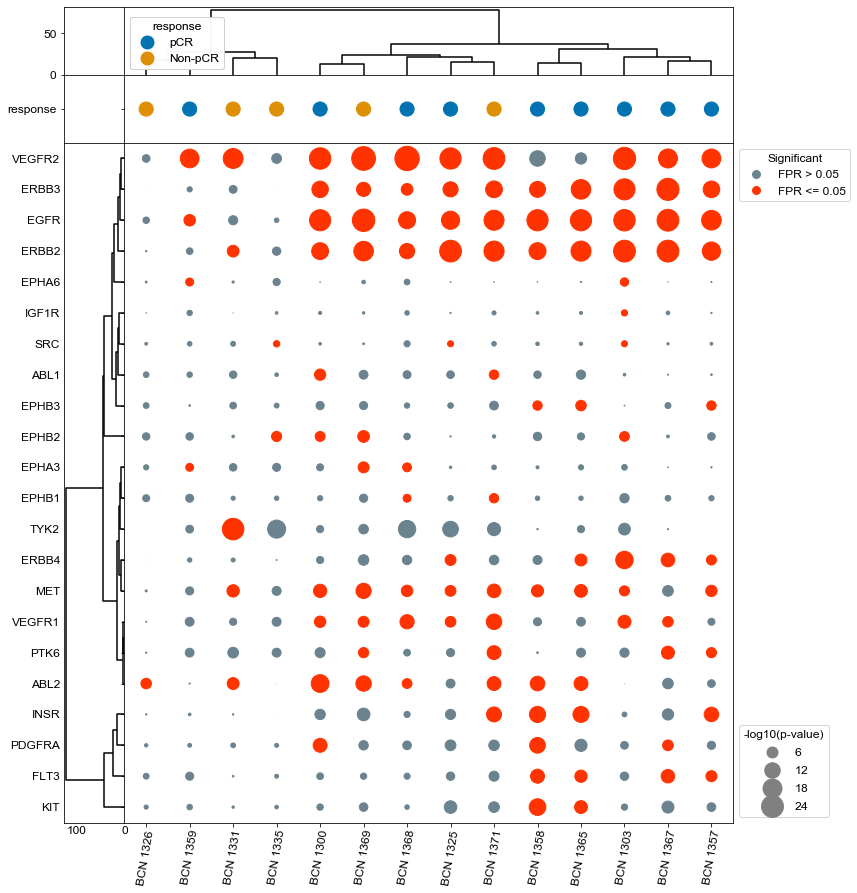

In [25]:
#Let's look just at pre-treatment samples 
#given the metadata, pull pre-treatment only and take subsets for plotting, sort by ERBB2 activity prediction
s1_temp = s1[s1['Treatment']=='pre-treatment']
#sample_ids = list(s1_temp['ID'])

nameDict = {}
for name, group in s1_temp.groupby('Patient ID'):
    #print(name, group['Sample ID'])
    nameDict[group['Sample ID'].values[0]] = name

s2 = s1_temp[s1_temp['Sample ID'].isin(list(nameDict.keys()))]
sample_ids = list(s2['ID'].values)

#create an x_label_dict
x_label_dict = {}
for index, row in s2.iterrows():
    x_label_dict[row['ID']] = row['Patient ID']
# How about we take just one sample of each of the patient IDS, when there are multiple pre-treatment samples


results = activities[sample_ids]
sig = fpr[sample_ids]
results = -np.log10(results)


#Setup a figure with a context strip at the top for HER2 status and activity dots on the below axis
fig, axes = plt.subplots(figsize = (12, 15), 
        nrows = 3, ncols = 2, 
        sharex = 'col', 
        sharey = 'row',
        gridspec_kw = {
            'height_ratios':[.1,0.1, 1], 
            'width_ratios':[0.1,1]
        },)
fig.subplots_adjust(wspace=0, hspace=0)

dots = dotplot.DotPlot(results, 
                       sig, 
                       alpha=0.05,
                       figsize = (10,15), 
                       dotsize = 20, 
                       legend_title='-log10(p-value)',
                      x_label_dict = x_label_dict, 
                      kinase_dict=kinase_dict)
#Cluster changes the sorting of the values array, so be sure to plot context last so that it is in the same sort.
dots.drop_kinases_with_no_significance()
method = 'ward'
dots.cluster(orientation = 'left', ax = axes[2,0], method=method)
dots.cluster(orientation = 'top', ax = axes[0,1], method=method)
dots.context(ax=axes[1,1], info = s2, id_column = 'ID', context_columns = ['response'], orientation = 'top', dotsize =200, markersize= 15 )

dots.dotplot(ax = axes[2,1])

plt.xticks(rotation = 80, FontSize=12)
plt.yticks(FontSize=12)
plt.savefig(odir+'microbiopsy_PreTreatment_all.pdf', bbox_inches='tight')

## Plot specific kinases for each patient (all samples)

In [18]:
kinases = list(activities.index)
kinases.remove('ERBB2')
kinases.remove('EGFR')

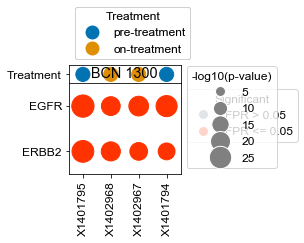

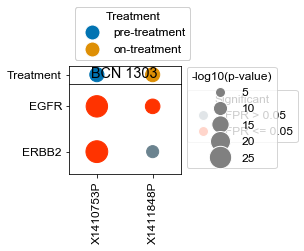

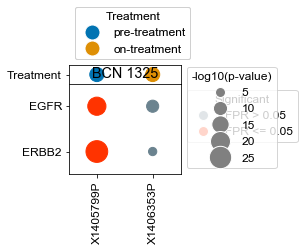

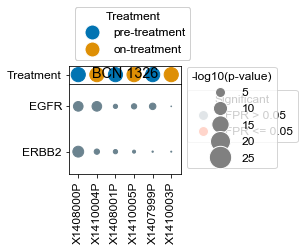

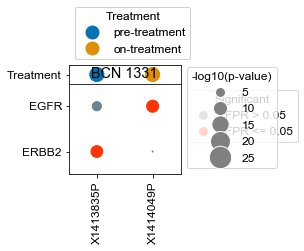

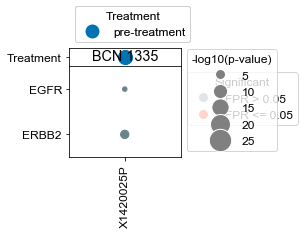

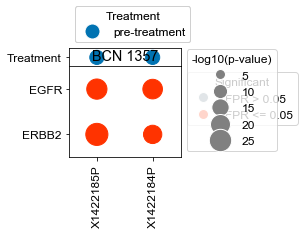

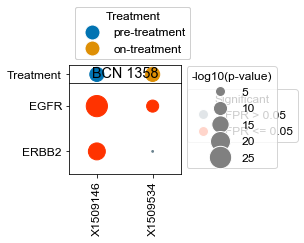

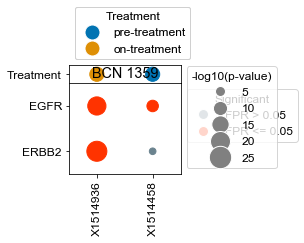

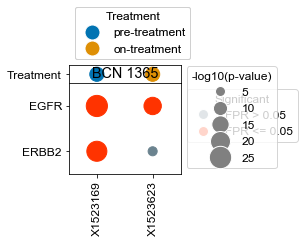

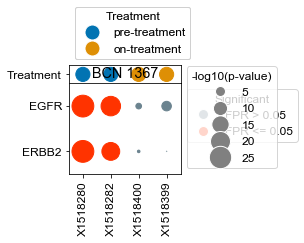

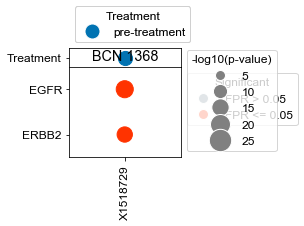

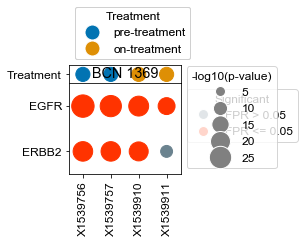

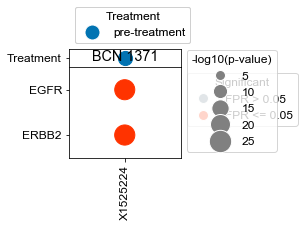

In [22]:
# What happens if we take, for each patient that has pre- and on-treatment, the difference in ERBB2 activity?
#find the paired sample ids 
for name, group in s1.groupby('Patient ID'):
    #let's just plot those results (ERBB2 kinase)
    #Let's look just at pre-treatment samples 
#given the metadata, pull pre-treatment only and take subsets for plotting, sort by ERBB2 activity prediction
    sample_ids = list(group['ID'])

    results = activities[sample_ids]
    results = results.sort_values('ERBB2', axis=1)
    sig = fpr[sample_ids]
    significance = fpr[sample_ids] <= 0.05
    significant = (results < significance.reindex(results.index)[results.columns]) * 1
    results = -np.log10(results)
#Setup a figure with a context strip at the top for HER2 status and activity dots on the below axis
    fig, axes = plt.subplots(figsize = (2,2), 
        nrows = 2, ncols = 1, 
        sharex = 'col', 
        sharey = 'row',
        gridspec_kw = {
            'height_ratios':[0.2,1], 
        },)
    fig.subplots_adjust(wspace=0, hspace=0)

    dots = dotplot.DotPlot(results, 
                       sig, 
                       figsize = (2,2), 
                       dotsize = 20, 
                       legend_title='-log10(p-value)')
#Cluster changes the sorting of the values array, so be sure to plot context last so that it is in the same sort.
    dots.drop_kinases(kinases)
    #dots.drop_kinases_with_no_significance()

    dots.context(ax=axes[0], info = group, id_column = 'ID', context_columns = ['Treatment'], orientation = 'top', dotsize =200, markersize= 15 )

    dots.dotplot(ax = axes[1], max_size=25)
    plt.title(name)
   
    plt.savefig(odir+'microbiopsy_patient_'+ name +'.pdf', bbox_inches='tight')
        

In [163]:
## Create a report by patient of change in ERBB2 values

for name, group in s1.groupby('Patient ID'):
    sample_ids = list(group['ID'])

    results = activities[sample_ids]
    ERBB2 = results.loc['ERBB2']
    
    print(name)
    
    ERBB2.values
    for sample in ERBB2.index.values:
        treatment = s1[s1['ID']==sample]['Treatment'].values[0]
        print("%s\t%s\t%.2e"%(treatment, sample, ERBB2[sample]))

BCN 1300
pre-treatment	data:X1401794	5.77e-12
on-treatment	data:X1402967	1.37e-14
pre-treatment	data:X1401795	1.44e-25
on-treatment	data:X1402968	7.01e-21
BCN 1303
pre-treatment	data:X1410753P	4.09e-25
on-treatment	data:X1411848P	1.82e-05
BCN 1325
pre-treatment	data:X1405799P	1.15e-20
on-treatment	data:X1406353P	1.33e-05
BCN 1326
pre-treatment	data:X1407999P	9.61e-01
on-treatment	data:X1410003P	9.36e-01
pre-treatment	data:X1408000P	8.66e-04
pre-treatment	data:X1408001P	6.69e-01
on-treatment	data:X1410004P	6.63e-03
on-treatment	data:X1410005P	7.36e-01
BCN 1331
pre-treatment	data:X1413835P	2.10e-05
on-treatment	data:X1414049P	9.81e-01
BCN 1335
pre-treatment	data:X1420025P	7.67e-03
BCN 1357
pre-treatment	data:X1422184P	1.28e-12
pre-treatment	data:X1422185P	7.23e-23
BCN 1358
pre-treatment	data:X1509146	4.12e-11
on-treatment	data:X1509534	9.51e-01
BCN 1359
pre-treatment	data:X1514458	9.94e-04
on-treatment	data:X1514936	8.47e-17
BCN 1365
pre-treatment	data:X1523169	6.43e-19
on-treatment	data